# K-NN on Amazon Food Reviews Data Set

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

Number of reviews: 400 
Number of users: 399 
Number of products: 241 
Timespan: Oct 1999 - Oct 2012 
Number of Attributes/Columns in data: 10

Attribute Information:

Id ProductId - unique identifier for the product, UserId - unqiue identifier for the user, ProfileName HelpfulnessNumerator - number of users who found the review helpful, HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not, Score - rating between 1 and 5, Time - timestamp for the review, Summary - brief summary of the review, Text - text of the review, Objective: Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

[Q] How to determine if a review is positive or negative?

[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

# Objective:

    * Given a review determine whether a review is positive or negative, by appling KNN algorithm and deciding the best Feature generation technique for given problem.

# 1. Loading the data
      
   * The dataset is available in two forms

    1.csv file
    2.SQLite Database
    
* I've processed 1000 points.

* I've cleaned the data on excel sheet and loaded the file as csv.file
 
* Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative". I've Given reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.

* In order to reduce the redundancy, I've eliminated the rows having same parameters

In [4]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
import scikitplot.metrics as skplt
from sklearn.metrics import classification_report
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
import warnings
warnings.filterwarnings("ignore")

data = pd.read_csv("KNN Assignment.csv") #Loaded the data as csv.file

#looking at the number of attributes and size of the data

data.shape
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,Positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,Negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,Positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,Positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...
4,5,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,Positive,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...


In [2]:
#Before starting the next phase of preprocessing lets see the number of entries left
data.shape

(1000, 10)

In [3]:
#How many positive and negative reviews are present in our dataset?
data['Score'].value_counts()

Positive    830
Negative    170
Name: Score, dtype: int64

# 2. Time Based Splitting

In [5]:
#Before we do Data Cleaning, we should sort our data 
import datetime

data["Time"] = data["Time"].map(lambda t: datetime.datetime.fromtimestamp(int(t)).strftime('%Y-%m-%d %H:%M:%S'))

#Here, I've sorted the data by 'ProductID' and deleted the duplicates
sortedData = data.sort_values('ProductId',axis=0,kind="quicksort", ascending=True)
final_data = sortedData.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep="first",inplace=False)

In [6]:
#sorting the data by timestamp so that it can be divided into train and test dataset for time based slicing.
final = final_data.sort_values('Time',axis=0,kind="quicksort", ascending=True).reset_index(drop=True)

In [7]:
print(final.shape)

(1000, 10)


In [8]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,999,B000084E1U,A3DH85EYHW4AQH,Eric Hochman,1,1,Positive,2006-02-24 05:30:00,Cats love it!,I have nine cats and they are crazy about thes...
1,984,B002NVPPHC,A31YYS8JRQAZP8,"Rena ""Rena""",0,0,Positive,2006-08-19 05:30:00,the best!,dum dum lolly pops are the best! they come i l...
2,905,B000CQG862,A3HXPEOW4KN19,Dawn Marakby,2,2,Positive,2006-09-15 05:30:00,Best Tea EVER!!,"I ordered the White Christmas, Christmas Eve, ..."
3,580,B000G6MBX2,A4AYT6I29WTPY,"Chip Lover ""Leisa""",4,5,Positive,2006-09-18 05:30:00,"Amazing Taste, Best Chip Ever!",I can't believe how wonderful this chip is! Th...
4,907,B000CQG862,AGV2SUHV9P47T,M. Power,0,0,Positive,2006-11-13 05:30:00,Makes everything better,Christmas Eve tea (which does not actually con...


# 3. Text Preprocessing: Stemming, stop-word removal and Lemmatization.

In [9]:
#find sentences containing html tags
import re
i=0;
for sent in final['Text'].values:
    if(len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
        i +=1;

0
McCann's Instant Oatmeal is great if you must have your oatmeal but can only scrape together two or three minutes to prepare it. There is no escaping the fact, however, that even the best instant oatmeal is nowhere near as good as even a store brand of oatmeal requiring stovetop preparation.  Still, the McCann's is as good as it gets for instant oatmeal. It's even better than the organic, all-natural brands I have tried.  All the varieties in the McCann's variety pack taste good.  It can be prepared in the microwave or by adding boiling water so it is convenient in the extreme when time is an issue.<br /><br />McCann's use of actual cane sugar instead of high fructose corn syrup helped me decide to buy this product.  Real sugar tastes better and is not as harmful as the other stuff. One thing I do not like, though, is McCann's use of thickeners.  Oats plus water plus heat should make a creamy, tasty oatmeal without the need for guar gum. But this is a convenience product.  Maybe the 

In [10]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'between', 'wasn', 'during', 'should', "doesn't", 'd', 'her', 'who', 'here', 'that', 'about', 'he', 'hasn', 'be', "isn't", 'them', "needn't", 'you', 'yourself', 'ours', 'from', 'too', 'does', 'where', 'why', 'nor', "aren't", 'haven', "you'd", "don't", 'ma', 'but', 'at', 'with', 'we', 'for', "didn't", "wasn't", 'mustn', 'o', 'out', 'will', 'were', "that'll", "weren't", 'these', 'doesn', "it's", 'because', 'now', 'above', 'mightn', 'don', 'it', 't', 'ain', 'are', 'other', 'm', "haven't", 'its', 'any', 'doing', "shan't", 'down', 'whom', 'i', 'me', 'few', "she's", 'my', 'how', "you've", 'won', 'herself', 'while', 'same', 'very', 'such', 'and', 'if', 'most', 'the', 'just', 'when', 'needn', 'so', 've', 'is', 'as', 'to', 'y', "hadn't", 'being', 'those', 'can', 'having', 'against', 'him', "hasn't", 'theirs', 'they', 'off', 'an', 'once', 'through', 'their', 'into', 'themselves', 'weren', "couldn't", 'yours', 'myself', 'over', 'both', 'has', "should've", 'wouldn', "shouldn't", 'all', 'by', 'aga

In [11]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase

i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (data['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(data['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [12]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 

In [13]:
final.head(3) #below the processed review can be seen in the CleanedText Column 

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,999,B000084E1U,A3DH85EYHW4AQH,Eric Hochman,1,1,Positive,2006-02-24 05:30:00,Cats love it!,I have nine cats and they are crazy about thes...,b'nine cat crazi kibbl last thing want cat foo...
1,984,B002NVPPHC,A31YYS8JRQAZP8,"Rena ""Rena""",0,0,Positive,2006-08-19 05:30:00,the best!,dum dum lolly pops are the best! they come i l...,b'dum dum lolli pop best come lot kind tast re...
2,905,B000CQG862,A3HXPEOW4KN19,Dawn Marakby,2,2,Positive,2006-09-15 05:30:00,Best Tea EVER!!,"I ordered the White Christmas, Christmas Eve, ...",b'order white christma christma eve christma m...


In [14]:
final.shape

(1000, 11)

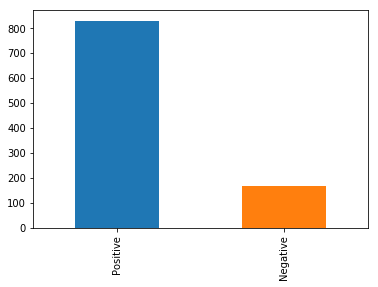

In [15]:
#Source:- https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplots.html

final['Score'].value_counts().plot(kind='bar')

# 4. Building function to find optimal K for KNN

In [16]:
#kd_tree

from sklearn.cross_validation import cross_val_score

def find_optimal_k(X_train,y_train, myList):
   
    #creating odd list of K for KNN
    myList = list(range(0,50))
    neighbors = list(filter(lambda x: x % 2 != 0, myList))

    # empty list that will hold cv scores
    cv_scores = []

    # perform 10-fold cross validation
    for k in neighbors:
        knn = KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree')
        scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
        cv_scores.append(scores.mean())

    # changing to misclassification error
    MSE = [1 - x for x in cv_scores]

    # determining best k
    optimal_k = neighbors[MSE.index(min(MSE))]
    print('\nThe optimal number of neighbors for Kd_Tree Algorithm is %d.' % optimal_k)

    plt.figure(figsize=(10,6))
    plt.plot(list(filter(lambda x: x % 2 != 0, myList)),MSE,color='red', linestyle='dashed', marker='o',
             markerfacecolor='green', markersize=10)
    plt.title('Kd_Tree: Error Rate vs. K Value')
    plt.xlabel('K')
    plt.ylabel('Error Rate')

    print("the misclassification error for each k value is : ", np.round(MSE,3))
    
    return optimal_k

In [17]:
#brute

from sklearn.cross_validation import cross_val_score

def find_brute_optimal_k(X_train,y_train, myList):
   
    #creating odd list of K for KNN
    myList = list(range(0,50))
    neighbors = list(filter(lambda x: x % 2 != 0, myList))

    # empty list that will hold cv scores
    cv_scores = []

    # perform 10-fold cross validation
    for k in neighbors:
        knn = KNeighborsClassifier(n_neighbors=k, algorithm='brute')
        scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
        cv_scores.append(scores.mean())

    # changing to misclassification error
    MSE = [1 - x for x in cv_scores]

    # determining best k
    brute_optimal_k = neighbors[MSE.index(min(MSE))]
    print('\nThe optimal number of neighbors for Brute Force Algorithm is %d.' % brute_optimal_k)

    plt.figure(figsize=(10,6))
    plt.plot(list(filter(lambda x: x % 2 != 0, myList)),MSE,color='red', linestyle='dashed', marker='o',
             markerfacecolor='green', markersize=10)
    plt.title('Brute Force: Error Rate vs. K Value')
    plt.xlabel('K')
    plt.ylabel('Error Rate')

    print("the misclassification error for each k value is : ", np.round(MSE,3))
    
    return brute_optimal_k

# 5. Applying Feature Generation Techniques to Convert Text to Numeric Vector.

# 5.1 Applying KNN with Bag of Words

Generationg Bag of Words Vector Matrix for Reviews (BOW)

In [18]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(final['Text'].values)

In [19]:
final_counts.get_shape()

(1000, 6014)

In [20]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
final_bow_np = StandardScaler(with_mean=False).fit_transform(final_counts)

Splitting Data into Train and Test

In [21]:
#We already have sorted data by timestamp so we will use first 70% of data as Train with cross validation and next 30% for test
import math
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

X = final_counts
y = final['Score']

X_train =  final_bow_np[:math.ceil(len(final)*.7)] 
X_test = final_bow_np[math.ceil(len(final)*.7):]
y_train = y[:math.ceil(len(final)*.7)]
y_test =  y[math.ceil(len(final)*.7):]

Finding Optimal K by 10 fold Cross validation


The optimal number of neighbors for Kd_Tree Algorithm is 7.
the misclassification error for each k value is :  [0.397 0.234 0.163 0.16  0.16  0.16  0.16  0.16  0.16  0.16  0.16  0.16
 0.16  0.16  0.16  0.16  0.16  0.16  0.16  0.16  0.16  0.16  0.16  0.16
 0.16 ]


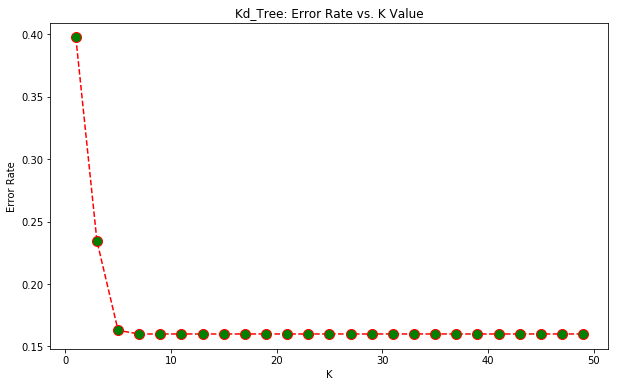

In [22]:
myList = list(range(0,50))
optimal_k = find_optimal_k(X_train,y_train,myList)

KNN with Kd_tree Optimal K

In [23]:
knn = KNeighborsClassifier(n_neighbors=optimal_k)
knn.fit(X_train, y_train)
pred = knn.predict(X_test)

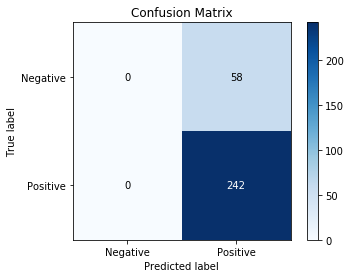

In [24]:
skplt.plot_confusion_matrix(y_test ,pred)

In [25]:
print(classification_report(y_test ,pred))

             precision    recall  f1-score   support

   Negative       0.00      0.00      0.00        58
   Positive       0.81      1.00      0.89       242

avg / total       0.65      0.81      0.72       300



In [26]:
# evaluate accuracy kd_tree
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for kd_tree is k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier for kd_tree is k = 7 is 80.666667%



The optimal number of neighbors for Brute Force Algorithm is 7.
the misclassification error for each k value is :  [0.397 0.234 0.163 0.16  0.16  0.16  0.16  0.16  0.16  0.16  0.16  0.16
 0.16  0.16  0.16  0.16  0.16  0.16  0.16  0.16  0.16  0.16  0.16  0.16
 0.16 ]


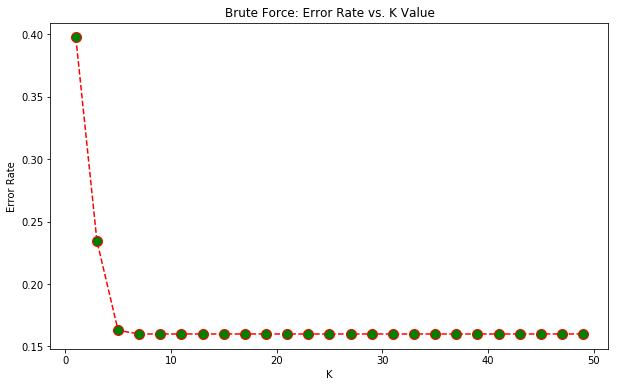

In [27]:
#Brute Force

myList = list(range(0,50))
brute_optimal_k = find_brute_optimal_k(X_train,y_train,myList)

KNN with Brute Optimal K

In [28]:
knn = KNeighborsClassifier(n_neighbors=brute_optimal_k)
knn.fit(X_train, y_train)
pred = knn.predict(X_test)

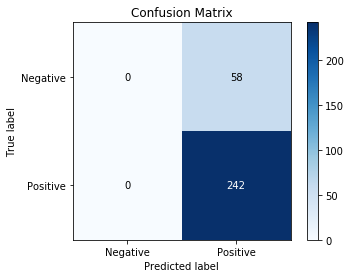

In [29]:
skplt.plot_confusion_matrix(y_test ,pred)

In [30]:
print(classification_report(y_test ,pred))

             precision    recall  f1-score   support

   Negative       0.00      0.00      0.00        58
   Positive       0.81      1.00      0.89       242

avg / total       0.65      0.81      0.72       300



In [31]:
# evaluate accuracy brute
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for Brute Force is k = %d is %f%%' % (brute_optimal_k, acc))


The accuracy of the knn classifier for Brute Force is k = 7 is 80.666667%


# Observations:-
    
    * I've applied Bag of Words (BOW) Feature Generation Technique to convert text to numeric vector.
    * I've already sorted the data by Time, So here I've divided the data into three parts
            1. Train Data (49%)
            2. Data for Cross Validation (21%)
            3. Test Data (30)
            
    * I've applied 10 fold cross validation to find the optimal K and applied both kd_tree and brute force algorithms
    
    * The optimal K value and test accuracy are same for both kd_tree and brute force alogorithms.
            
            Bag of Words (BOW) optimal K value is 7 & Test Accuracy is 80.66667%

# 5.2 Applying KNN with TF-IDF

Generating TF-IDF Vector Matrix for Reviews

In [32]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vec = TfidfVectorizer()#ngram_range=(2,2))

final_tfidf_count = tf_idf_vec.fit_transform(final_string)#final['Text'].values)

#print(final_string)

In [33]:
final_tfidf_count.get_shape()

(1000, 4091)

In [34]:
from sklearn.preprocessing import StandardScaler

final_tfidf_np = StandardScaler(with_mean=False).fit_transform(final_tfidf_count )

Splitting Data into Train & Test

In [35]:
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split

X = final_tfidf_count
y = final['Score']

X_train =  final_tfidf_count[:math.ceil(len(final)*.7)] 
X_test = final_tfidf_count[math.ceil(len(final)*.7):]
y_train = y[:math.ceil(len(final)*.7)]
y_test =  y[math.ceil(len(final)*.7):]

Finding Optimal K by 10 fold Cross validation


The optimal number of neighbors for Kd_Tree Algorithm is 9.
the misclassification error for each k value is :  [0.187 0.147 0.154 0.156 0.146 0.149 0.154 0.159 0.157 0.157 0.157 0.157
 0.157 0.157 0.157 0.157 0.16  0.16  0.16  0.16  0.16  0.16  0.16  0.16
 0.16 ]


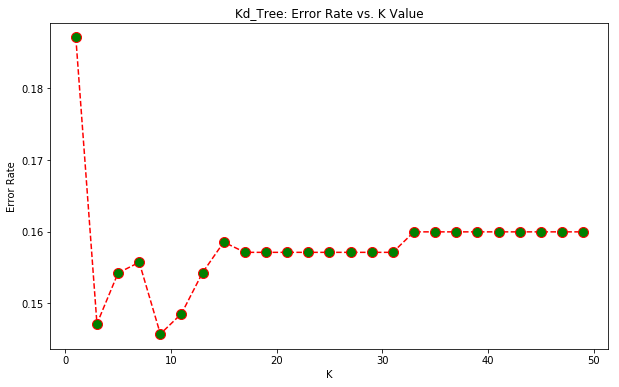

In [36]:
#Kd_Tree

myList = list(range(0,50))

tfidf_kd_optimal_k = find_optimal_k(X_train ,y_train,myList)

KNN with Kd_Tree Optimal K

In [37]:
knn = KNeighborsClassifier(n_neighbors=tfidf_kd_optimal_k)
knn.fit(X_train, y_train)
pred = knn.predict(X_test)

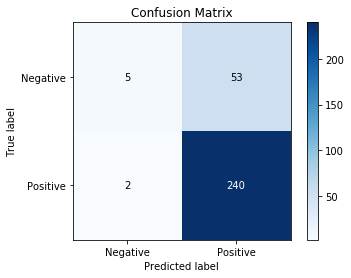

In [38]:
skplt.plot_confusion_matrix(y_test ,pred)

In [39]:
print(classification_report(y_test ,pred))

             precision    recall  f1-score   support

   Negative       0.71      0.09      0.15        58
   Positive       0.82      0.99      0.90       242

avg / total       0.80      0.82      0.75       300



In [40]:
# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for Kd_Tree algorithm is k = %d is %f%%' % (tfidf_kd_optimal_k, acc))


The accuracy of the knn classifier for Kd_Tree algorithm is k = 9 is 81.666667%



The optimal number of neighbors for Brute Force Algorithm is 9.
the misclassification error for each k value is :  [0.187 0.147 0.154 0.156 0.146 0.149 0.154 0.159 0.157 0.157 0.157 0.157
 0.157 0.157 0.157 0.157 0.16  0.16  0.16  0.16  0.16  0.16  0.16  0.16
 0.16 ]


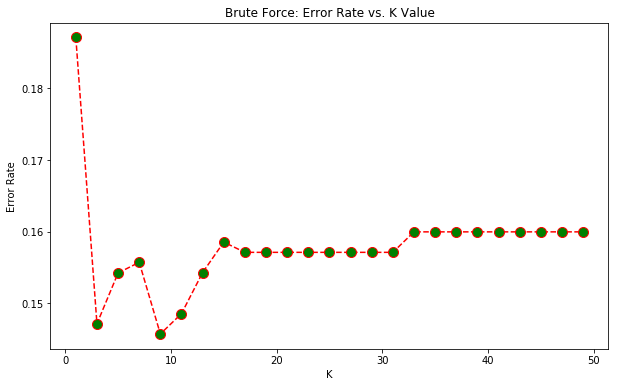

In [41]:
#Brute Force

myList = list(range(0,50))

tfidf_br_optimal_k = find_brute_optimal_k(X_train ,y_train,myList)

K-NN with Brute Force Optimal K

In [42]:
knn = KNeighborsClassifier(n_neighbors=tfidf_br_optimal_k)
knn.fit(X_train, y_train)
pred = knn.predict(X_test)

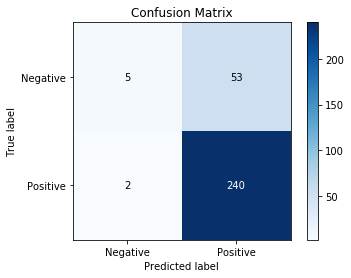

In [43]:
skplt.plot_confusion_matrix(y_test ,pred)

In [44]:
print(classification_report(y_test ,pred))

             precision    recall  f1-score   support

   Negative       0.71      0.09      0.15        58
   Positive       0.82      0.99      0.90       242

avg / total       0.80      0.82      0.75       300



In [45]:
# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for Brute Force Algorithm is k = %d is %f%%' % (tfidf_kd_optimal_k, acc))


The accuracy of the knn classifier for Brute Force Algorithm is k = 9 is 81.666667%


# Observations:-
    
    * I've applied Term Frequency Inverse Document Frequency Feature Generation Technique to convert text to numeric vector.
    * I've already sorted the data by Time, So here I've divided the data into three parts
            1. Train Data (49%)
            2. Data for Cross Validation (21%)
            3. Test Data (30%)
            
    * I've applied 10 fold cross validation to find the optimal K and applied both kd_tree and brute force algorithms
    
    * The optimal K value and test accuracy are same for both kd_tree and brute force alogorithms.
            
            TF-IDF optimal K value is 9 & Test Accuracy is 81.6%

# 5.3 Appling KNN with Avg W2V

Generating W2V Vector Matrix for Reviews

In [46]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

In [47]:
import gensim
i=0
str1=''
list_of_sent=[]
for sent in final['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    str1 = ''
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (cleaned_words.lower() not in stop)):    
                filtered_sentence.append(cleaned_words.lower())
                str1 += " "+cleaned_words.lower() 
            else:
                continue
    #str1 = b" ".join(filtered_sentence) #final string of cleaned words
            
    list_of_sent.append(filtered_sentence)


In [48]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [49]:
sent_vectors = []; 
for sent in list_of_sent: 
    sent_vec = np.zeros(50)
    cnt_words =0; 
    for word in sent: 
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

In [50]:
from sklearn.preprocessing import StandardScaler

final_w2v_count = StandardScaler().fit_transform(sent_vectors)

Splitting Data into Train and Test

In [51]:
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split

X = sent_vectors
y = final['Score']

X_train =  sent_vectors[:math.ceil(len(final)*.7)] 
X_test = sent_vectors[math.ceil(len(final)*.7):]
y_train = y[:math.ceil(len(final)*.7)]
y_test =  y[math.ceil(len(final)*.7):]

Finding Optimal K by 10 fold Cross validation


The optimal number of neighbors for Kd_Tree Algorithm is 13.
the misclassification error for each k value is :  [0.288 0.204 0.189 0.169 0.163 0.161 0.16  0.16  0.16  0.16  0.16  0.16
 0.16  0.16  0.16  0.16  0.16  0.16  0.16  0.16  0.16  0.16  0.16  0.16
 0.16 ]


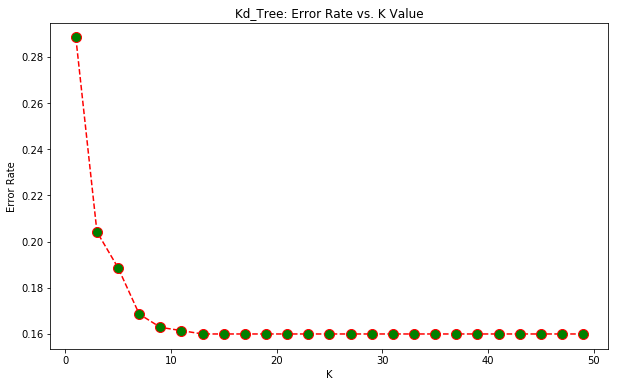

In [52]:
#Kd_tree

myList = list(range(0,40))

w2v_kd_optimal_k = find_optimal_k (X_train ,y_train,myList)

KNN with Kd_Tree Optimal K

In [53]:
knn = KNeighborsClassifier(n_neighbors=w2v_kd_optimal_k)
knn.fit(X_train, y_train)
pred = knn.predict(X_test)

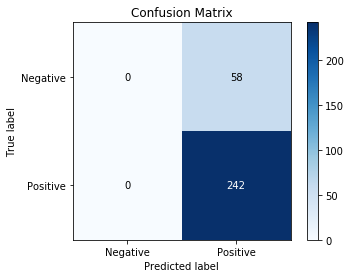

In [54]:
skplt.plot_confusion_matrix(y_test ,pred)

In [55]:
print(classification_report(y_test ,pred))

             precision    recall  f1-score   support

   Negative       0.00      0.00      0.00        58
   Positive       0.81      1.00      0.89       242

avg / total       0.65      0.81      0.72       300



In [56]:
# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for Kd_Tree Algorithm is k = %d is %f%%' % (w2v_kd_optimal_k, acc))


The accuracy of the knn classifier for Kd_Tree Algorithm is k = 13 is 80.666667%



The optimal number of neighbors for Brute Force Algorithm is 13.
the misclassification error for each k value is :  [0.288 0.204 0.189 0.169 0.163 0.161 0.16  0.16  0.16  0.16  0.16  0.16
 0.16  0.16  0.16  0.16  0.16  0.16  0.16  0.16  0.16  0.16  0.16  0.16
 0.16 ]


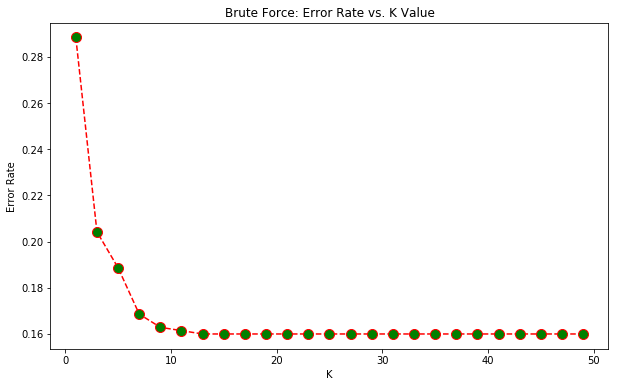

In [57]:
#Brute Force

myList = list(range(0,50))

w2v_br_optimal_k = find_brute_optimal_k (X_train ,y_train,myList)

KNN with Brute Force Optimal K

In [58]:
knn = KNeighborsClassifier(n_neighbors=w2v_br_optimal_k)
knn.fit(X_train, y_train)
pred = knn.predict(X_test)

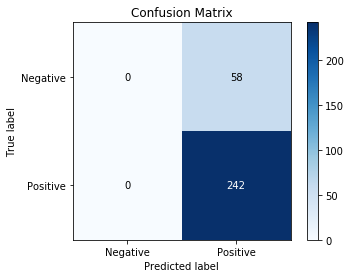

In [59]:
skplt.plot_confusion_matrix(y_test ,pred)

In [60]:
print(classification_report(y_test ,pred))

             precision    recall  f1-score   support

   Negative       0.00      0.00      0.00        58
   Positive       0.81      1.00      0.89       242

avg / total       0.65      0.81      0.72       300



In [61]:
# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for Brute Force Algorithm is k = %d is %f%%' % (w2v_br_optimal_k, acc))


The accuracy of the knn classifier for Brute Force Algorithm is k = 13 is 80.666667%


# Observations:-
    
    * I've first applied Word2Vec and computed the average w2v for each review and then coverted the text to numeric vector.
    * I've already sorted the data by Time, So here I've divided the data into three parts
            1. Train Data (49%)
            2. Data for Cross Validation (21%)
            3. Test Data (30%)
            
    * I've applied 10 fold cross validation to find the optimal K and applied both kd_tree and brute force algorithms
    
    * The optimal K value and test accuracy are same for both kd_tree and brute force alogorithms.
            
            Word2Vec optimal K value is 13 & Test Accuracy is 80.6%

# 5.4 Appling KNN with tf-idf weighted W2V

Generating TF-IDF W2V Vector matrix for Reviews

In [77]:
import gensim
i=0
str1=''
final_string_for_tfidf = []
for sent in final['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    str1 = ''
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (cleaned_words.lower() not in stop)):    
                filtered_sentence.append(cleaned_words.lower())
                str1 += " "+cleaned_words.lower() 
            else:
                continue
    #str1 = b" ".join(filtered_sentence) #final string of cleaned words
            
    #final_string_for_tfidf.append(str1)
    final_string_for_tfidf.append((str1).strip())

In [78]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vec_w = TfidfVectorizer()#ngram_range=(2,2))

final_tfidf_w = tf_idf_vec_w.fit_transform(final_string_for_tfidf)

In [79]:
tfidf_feat = tf_idf_vec_w.get_feature_names()


tfidf_sent_vectors = [];
row=0;
for sent in list_of_sent:  
    sent_vec = np.zeros(50) 
    weight_sum =0;
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            tf_idf = final_tfidf_w[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except Exception as e: 
            pass #print(e)
            
    try:
        sent_vec /= weight_sum
    except:
        print(e)
        
    tfidf_sent_vectors.append(sent_vec)
    row += 1

In [80]:
from sklearn.preprocessing import StandardScaler

final_tfidf_w2v_np = StandardScaler().fit_transform(tfidf_sent_vectors )

In [81]:
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier


X = final_tfidf_w2v_np
y = final['Score']

X_train =  final_tfidf_w2v_np[:math.ceil(len(final)*.7)] 
X_test = final_tfidf_w2v_np[math.ceil(len(final)*.7):]
y_train = y[:math.ceil(len(final)*.7)]
y_test =  y[math.ceil(len(final)*.7):]

Finding Optimal K by 10 fold Cross validation


The optimal number of neighbors for Kd_Tree Algorithm is 17.
the misclassification error for each k value is :  [0.261 0.2   0.17  0.164 0.163 0.163 0.161 0.161 0.16  0.16  0.16  0.16
 0.16  0.16  0.16  0.16  0.16  0.16  0.16  0.16  0.16  0.16  0.16  0.16
 0.16 ]


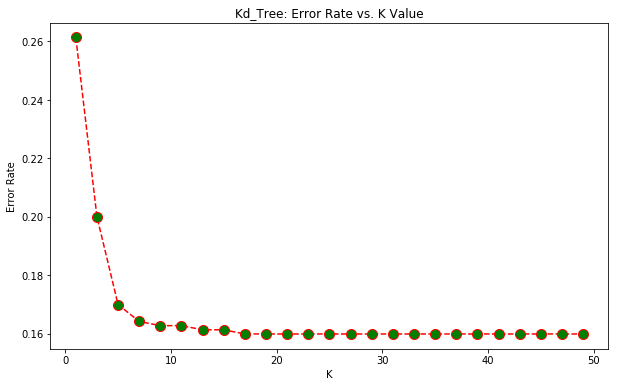

In [82]:
#Kd_tree

myList = list(range(0,40))

tfidf_w2v_optimal_k = find_optimal_k(X_train ,y_train,myList)

KNN with Kd_tree Optimal K

In [83]:
knn = KNeighborsClassifier(n_neighbors=tfidf_w2v_optimal_k)
knn.fit(X_train, y_train)
pred = knn.predict(X_test)

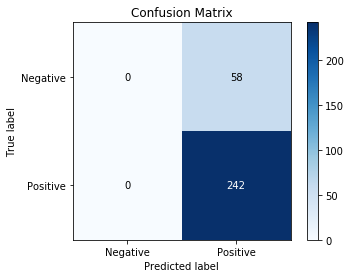

In [84]:
skplt.plot_confusion_matrix(y_test ,pred)

In [85]:
print(classification_report(y_test ,pred))

             precision    recall  f1-score   support

   Negative       0.00      0.00      0.00        58
   Positive       0.81      1.00      0.89       242

avg / total       0.65      0.81      0.72       300



In [86]:
# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for Kd_Tree Algorithm is k = %d is %f%%' % (tfidf_w2v_optimal_k, acc))


The accuracy of the knn classifier for Kd_Tree Algorithm is k = 17 is 80.666667%



The optimal number of neighbors for Brute Force Algorithm is 17.
the misclassification error for each k value is :  [0.261 0.2   0.17  0.164 0.163 0.163 0.161 0.161 0.16  0.16  0.16  0.16
 0.16  0.16  0.16  0.16  0.16  0.16  0.16  0.16  0.16  0.16  0.16  0.16
 0.16 ]


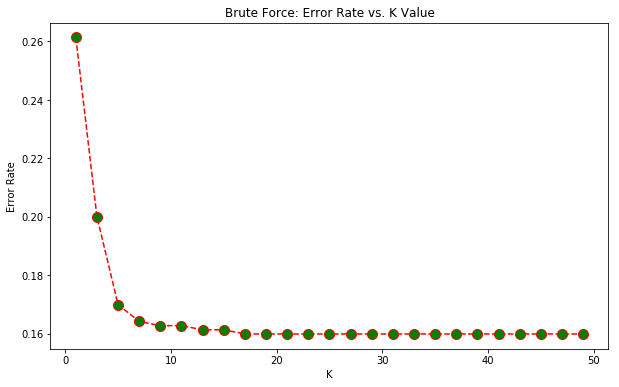

In [87]:
#Brute Force

myList = list(range(0,40))

tfidfbr_w2v_optimal_k = find_brute_optimal_k(X_train ,y_train,myList)

KNN with Brute Force Optimal K

In [88]:
knn = KNeighborsClassifier(n_neighbors=tfidfbr_w2v_optimal_k)
knn.fit(X_train, y_train)
pred = knn.predict(X_test)

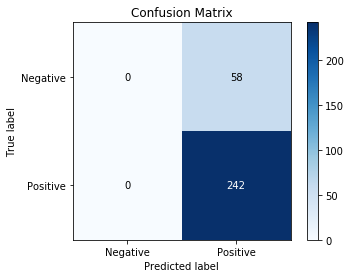

In [89]:
skplt.plot_confusion_matrix(y_test ,pred)

In [90]:
print(classification_report(y_test ,pred))

             precision    recall  f1-score   support

   Negative       0.00      0.00      0.00        58
   Positive       0.81      1.00      0.89       242

avg / total       0.65      0.81      0.72       300



In [91]:
# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (tfidfbr_w2v_optimal_k, acc))


The accuracy of the knn classifier for k = 17 is 80.666667%


# Observations:-
    
    * I've applied TF-IDF Word2Vec Feature Generation Technique to convert text to numeric vector.
    * I've already sorted the data by Time, So here I've divided the data into three parts
            1. Train Data (49%)
            2. Data for Cross Validation (21%)
            3. Test Data (30%)
            
    * I've applied 10 fold cross validation to find the optimal K and applied both kd_tree and brute force algorithms
    
    * The optimal K value and test accuracy are same for both kd_tree and brute force alogorithms.
            
            Word2Vec optimal K value is 17 & Test Accuracy is 80.6%

# 6. Conclusion: 
    
    * The result of feature generation techniques and machine learning algorithms vary by application. But by comparing the accuracy of all 4 developed models, KNN model with TF-IDF feature generation technique gives accuracy more than 81% which is the best to predict the polarity of reviews among all models. The best optimal K value is 9.

# 7. K-NN on Amazon Data set - Tabular Result

In [96]:
dataframe = pd.DataFrame(
{
    "Model": ['BOW','TF-IDF','WORD2VEC','AVG W2V'],
    "Hyper Parameter (K=)": [7,9,13,17],
    "Train Error (%)": [16,14,16,16],
    "Test Accuracy (%)": [80.6,81.6,80.6,80.6]
}
)
dataframe

,Model,Hyper Parameter (K=),Train Error (%),Test Accuracy (%)
0,BOW,7,16,80.6
1,TF-IDF,9,14,81.6
2,WORD2VEC,13,16,80.6
3,AVG W2V,17,16,80.6
